In [1]:
import networkx as nx
from neo4j import GraphDatabase
import pandas as pd
from pyvis.network import Network
import matplotlib.pyplot as plt
from netgraph import Graph  # https://netgraph.readthedocs.io/en/latest/

In [2]:
driver = GraphDatabase.driver("bolt://neo4j:7687", auth=("neo4j", "BDII2023"))
session = driver.session()

In [3]:
def run_query(query, return_data=True, session=session, **kwargs):
    results = session.run(query, kwargs)
    if return_data:
        return results.data()
    return results

### 1. **Mapamundi**: El mapamundi debe mostrar las distintas áreas del juego y como se interconectan unas con otras.


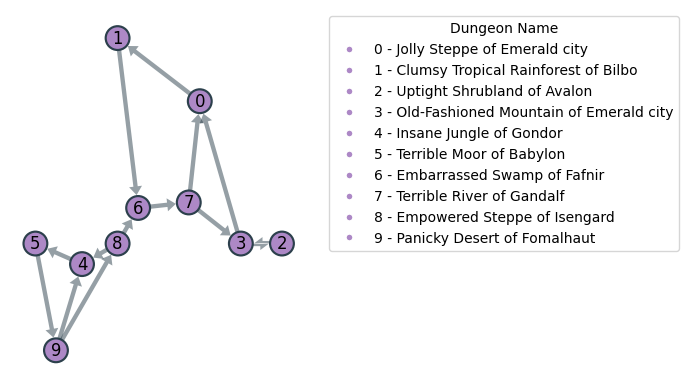

In [4]:
data = run_query("""
MATCH (a1:Area)-[r:SHORTEST_PATH]->(a2:Area)
RETURN a1.name as source, a2.name as target, r.length as length
""")

G = nx.DiGraph()

# Node mapping to integers and reverse mapping for legend
node_to_int = {}
int_to_node = {}
node_counter = 0

for row in data:
    if row['source'] not in node_to_int:
        node_to_int[row['source']] = node_counter
        int_to_node[node_counter] = row['source']
        node_counter += 1
    if row['target'] not in node_to_int:
        node_to_int[row['target']] = node_counter
        int_to_node[node_counter] = row['target']
        node_counter += 1
    G.add_edge(node_to_int[row['source']], node_to_int[row['target']])

# Visualization
fig, ax = plt.subplots()
node_color = "#AD88C6"
g = Graph(
    G,
    node_layout="radial",
    arrows=True,
    node_labels=True,
    # edge_layout="curved",
    node_size=3,
    node_color=node_color,
    ax=ax,
)

# Create a legend mapping integers back to node names
legend_handles = [plt.Line2D([], [], marker="o", color="w", label=f"{i} - {int_to_node[i]}",
                             markerfacecolor=node_color, markersize=5) for i in int_to_node]
ax.legend(handles=legend_handles, title="Dungeon Name", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### 2. **Listado mazmorras**: El listado de mazmorras debe mostrar todas las mazmorras del juego y las áreas con las que están conectadas. Debería ser capaz de ver a simple vista que mazmorras están en cada área y mazmorras hacen de puente entre dos áreas.


In [5]:
# Assuming run_query function returns the needed data as previously defined
data = pd.DataFrame(run_query("""
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""))


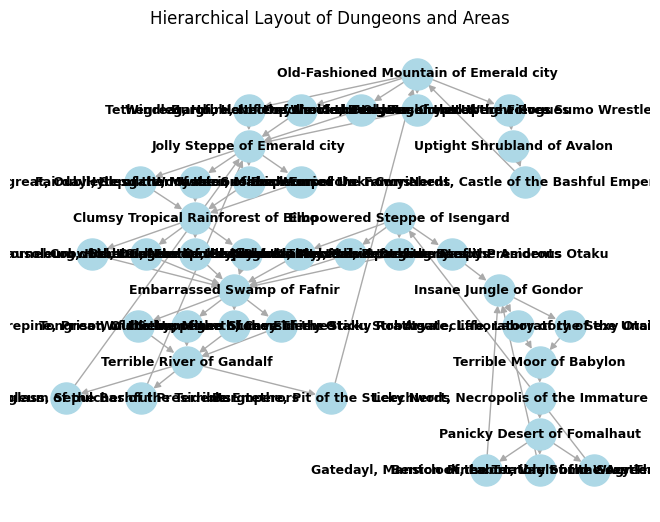

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on your existing data
for index, row in data.iterrows():
    source = row['source']
    target = row['target']
    dungeon = row['dungeon_name']
    
    G.add_edge(source, dungeon)
    G.add_edge(dungeon, target)

# Use graphviz to layout the graph hierarchically
pos = graphviz_layout(G, prog="dot")  # 'dot' algorithm is used for hierarchical structure

# Draw the graph
nx.draw(G, pos, node_size=500, node_color='lightblue', font_size=9, font_weight='bold', edge_color='#AAAAAA')
plt.title('Hierarchical Layout of Dungeons and Areas')
plt.show()


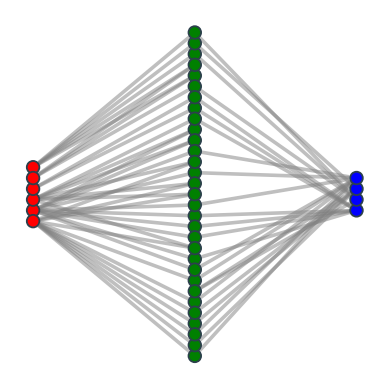

In [67]:
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph, get_multipartite_layout

# Initialize the directed graph
G = nx.DiGraph()

# Adding nodes and edges to the graph
for index, row in data.iterrows():
    source = row['source']
    target = row['target']
    dungeon = row['dungeon_name']
    
    # Add nodes with their types as attributes
    G.add_node(source, type='source_area')
    G.add_node(target, type='target_area')
    G.add_node(dungeon, type='dungeon')

    # Add edges between areas and corresponding dungeons
    G.add_edge(source, dungeon)
    G.add_edge(dungeon, target)

# Define layers for the multipartite layout
source_nodes = {node for node, attr in G.nodes(data=True) if attr['type'] == 'source_area'}
target_nodes = {node for node, attr in G.nodes(data=True) if attr['type'] == 'target_area'}
dungeon_nodes = {node for node, attr in G.nodes(data=True) if attr['type'] == 'dungeon'}

layers = [list(source_nodes), list(dungeon_nodes), list(target_nodes)]

# Generating the multipartite layout for all nodes
node_positions = get_multipartite_layout(G.edges(), layers)

# Visualization
fig, ax = plt.subplots()
g = Graph(
    G,
    node_layout=node_positions,
    node_color={node: 'red' if attr['type'] == 'source_area' else 'blue' if attr['type'] == 'target_area' else 'green' for node, attr in G.nodes(data=True)},
    edge_color='gray',
    node_size=2,
    arrow=True,
    ax=ax
)

plt.show()

TypeError: get_multipartite_layout() missing 1 required positional argument: 'layers'

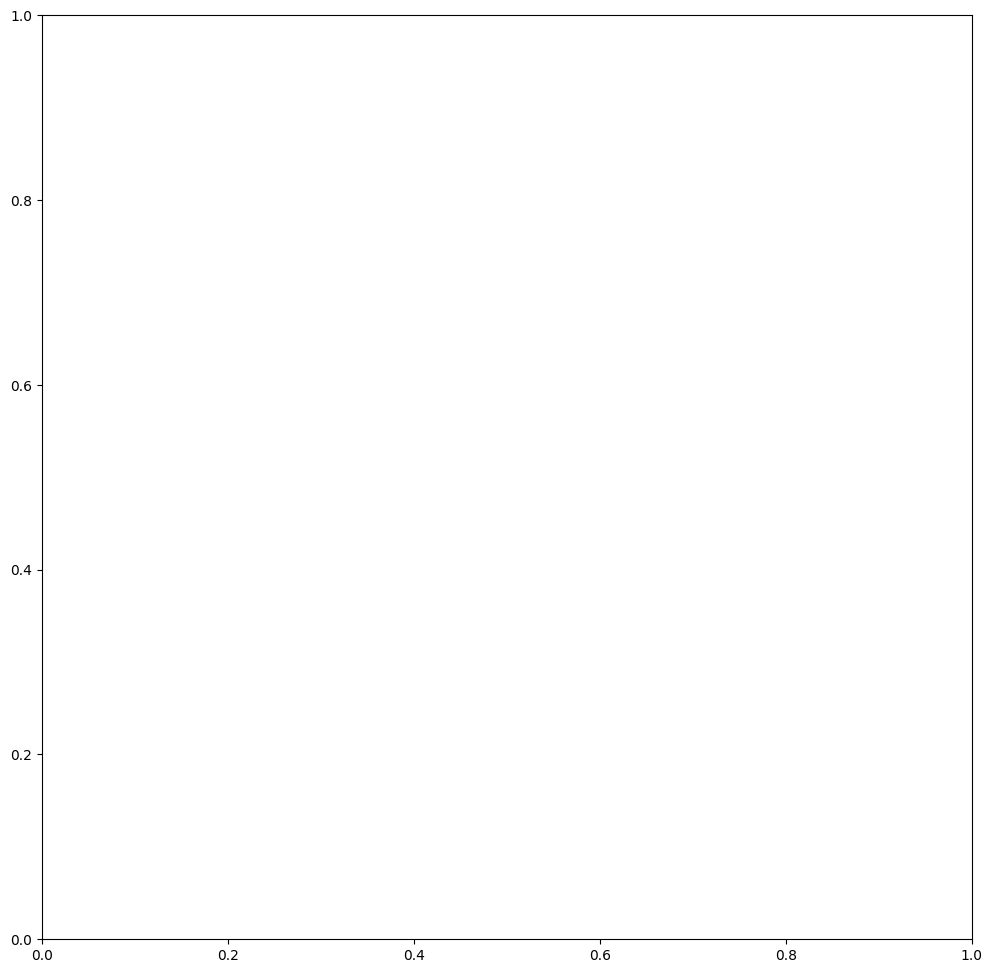

In [52]:
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph
import pandas as pd

# Assuming run_query function returns the needed data as previously defined
data = pd.DataFrame(run_query("""
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""))

G = nx.DiGraph()

# Tripartite graph area -> dungeon -> area
for row in data.itertuples():
    G.add_node(row.source, type='area1')
    G.add_node(row.target, type='area2')
    G.add_node(row.dungeon_name, type='dungeon')
    G.add_edge(row.source, row.dungeon_name)
    G.add_edge(row.dungeon_name, row.target)

# Colors and position
node_colors = {node: 'blue' if data['type'] == 'area1' or data['type'] == 'area2' else 'red' for node, data in G.nodes(data=True)}

# Visualization using netgraph
fig, ax = plt.subplots(figsize=(12, 12))
g = Graph(
    G,
    node_layout="multipartite",
    node_color=node_colors,
    node_size=2,  # Adjust as necessary
    edge_layout="straight",
    ax=ax
)

# Creating legends for areas and dungeons
area_legend = [plt.Line2D([0], [0], marker='o', color='w', label='Area',
                          markerfacecolor='blue', markersize=10)]
dungeon_legend = [plt.Line2D([0], [0], marker='o', color='w', label='Dungeon',
                             markerfacecolor='red', markersize=10)]

ax.legend(handles=area_legend + dungeon_legend, title="Node Types", loc='upper right')

plt.show()


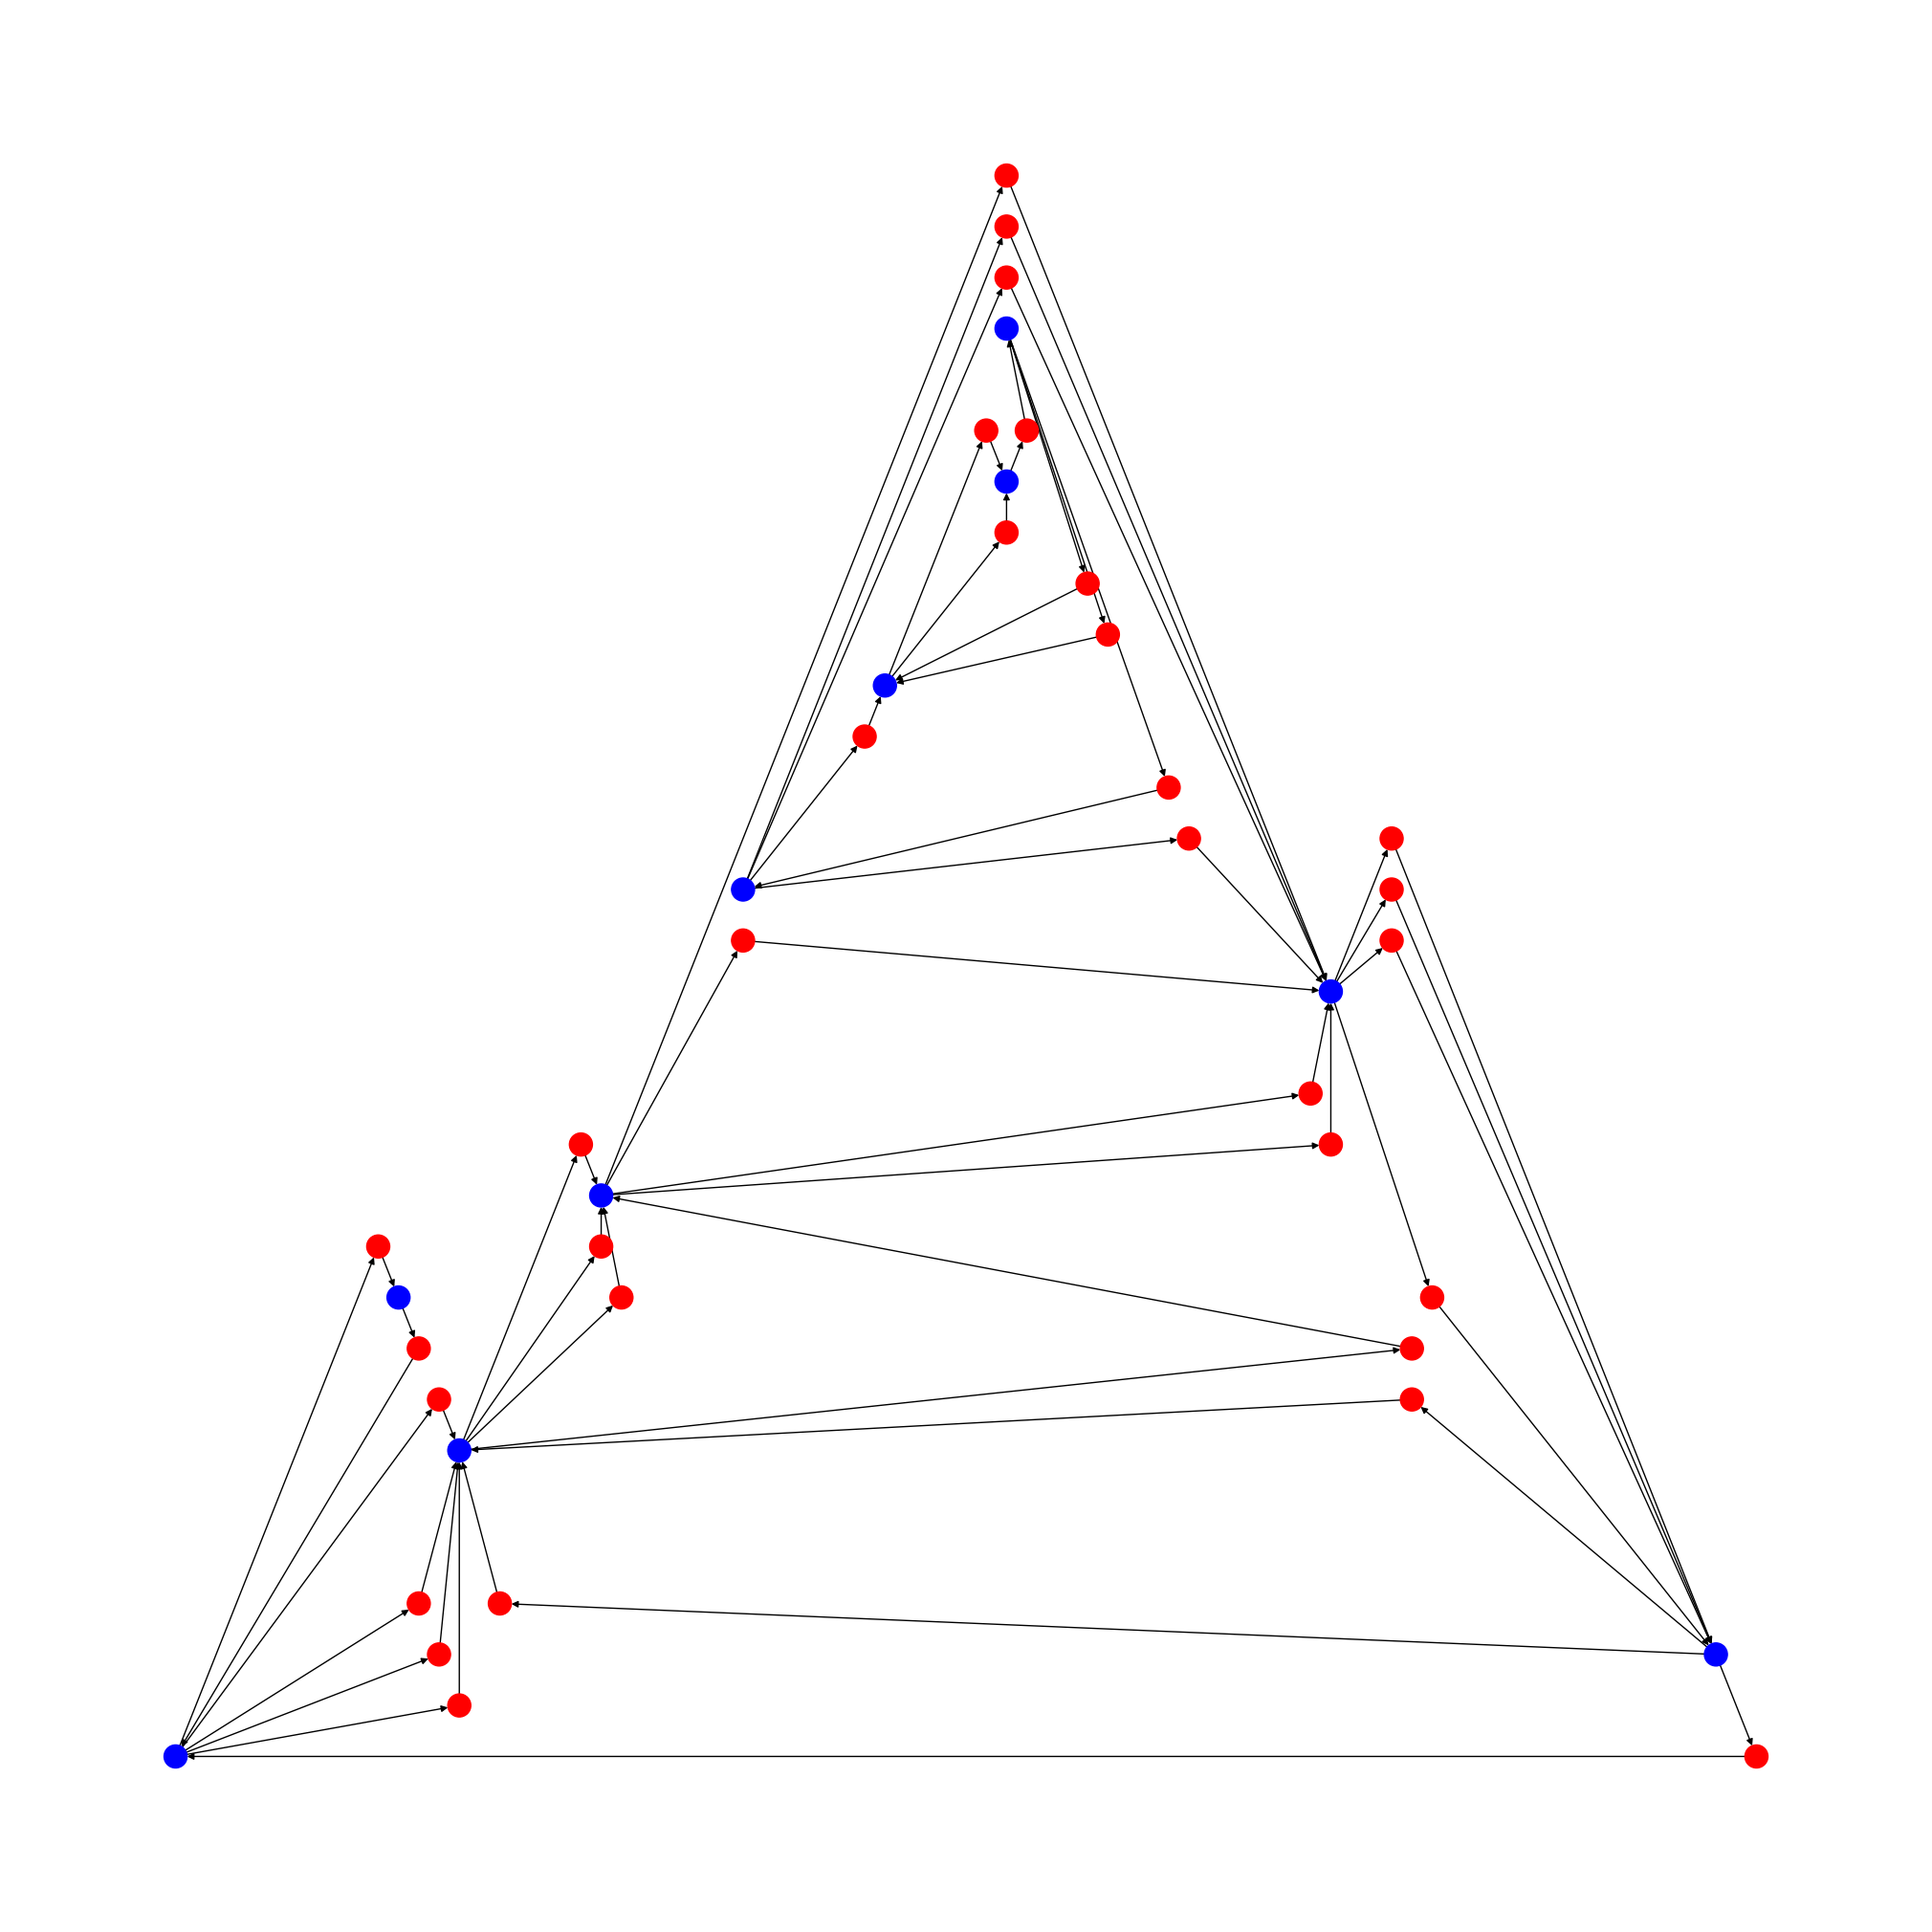

In [49]:
query = """
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""
data = pd.DataFrame(run_query(query))
G = nx.DiGraph()
# Tripartite graph area -> dungeon -> area
for i, row in enumerate(data.itertuples()):
    source_node = {'name': row.source, 'type': 'area1'}
    target_node = {'name': row.target, 'type': 'area2'}
    dungeon_node = {'name': row.dungeon_name, 'type': 'dungeon'}
    G.add_node(row.source, **source_node)
    G.add_node(row.target, **target_node)
    G.add_node(row.dungeon_name, **dungeon_node)
    G.add_edge(row.source, row.dungeon_name)
    G.add_edge(row.dungeon_name, row.target)

# Set the position of each node 
# color = ['blue' if node[1]['type'] in ['area1', 'area2'] else 'green' for node in G.nodes(data=True)]
color = {node[0]: 'blue' if node[1]['type'] in ['area1', 'area2'] else 'red' for node in G.nodes(data=True)}

pos = nx.planar_layout(G)

plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=False, node_color=color.values(), pos=pos, font_size=10)

In [115]:
for node in G.nodes:
    G.nodes[node]['x'] = pos[node][0]
    G.nodes[node]['y'] = pos[node][1]
    G.nodes[node]['color'] = color[node]
    if color[node] == 'red':
        G.nodes[node]['shape'] = 'box'
net = Network(notebook=True, directed=True)
net.from_nx(G)
net.show("graph.html", notebook=True)


graph.html


In [ ]:
query = """
MATCH (a: Area),
      (b: Area),
      (a)-[ca:IS_CONNECTED]->(),
      ()-[cb:IS_CONNECTED]->(b),
       p = shortestPath((a)-[:IS_CONNECTED*]->(b))
WHERE a <> b AND ca.dungeon_name = cb.dungeon_name
RETURN a.name as source, b.name as target, ca.dungeon_name as dungeon_name
"""
data = pd.DataFrame(run_query(query))


### 3. **Mini-mapa mazmorra**: Dada una mazmorra el mini mapa debe mostrar información que ayude a los aventureros a explorar la mazmorra. En el mini mapa debe ser fácil reconocer las entradas y las salidas de una mazmorra. Los pasillos que llevan a salas interesantes. Las zonas donde hay monstruos o tesoros y el nivel/precio de estos

In [99]:
import matplotlib.pyplot as plt
mazmorra = "Bentclock, Laboratory of the Sexy Thieves"
query_dungeon_map = """
MATCH (r1: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(r2: Room{dungeon_name: $mazmorra})
RETURN r1.room_name as source, r2.room_name as target
"""
data = pd.DataFrame(run_query(query_dungeon_map, mazmorra=mazmorra))
query_entry_exit = """
MATCH (a: Area)-[:IS_CONNECTED]->(r_entry: Room{dungeon_name: $mazmorra}),
        (r_exit: Room{dungeon_name: $mazmorra})-[:IS_CONNECTED]->(b: Area)
RETURN r_entry.room_name as entry, r_exit.room_name as exit
"""
entry_exit = run_query(query_entry_exit, mazmorra=mazmorra)[0]
query_monsters = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c_m:CONTAINS]->(m: Monster)
RETURN r.room_name as room, m.name as monster, c_m.amount as amount_monsters
"""
monsters = pd.DataFrame(run_query(query_monsters, mazmorra=mazmorra))
query_loot = """
MATCH (r: Room{dungeon_name: $mazmorra})-[c_l:CONTAINS]->(l: Loot)
RETURN r.room_name as room, l.name as loot, c_l.amount as amount_loot
"""
query_max_level = """
MATCH (r: Room{dungeon_name: $mazmorra})-[:CONTAINS]->(m: Monster)
RETURN r.room_name as room, max(m.level) as max_level
"""
max_level = pd.DataFrame(run_query(query_max_level, mazmorra=mazmorra))
query_max_gold = """
MATCH (r: Room{dungeon_name: $mazmorra})-[:CONTAINS]->(l: Loot)
RETURN r.room_name as room, max(l.gold) as max_gold
"""
max_gold = pd.DataFrame(run_query(query_max_gold, mazmorra=mazmorra))
loot = pd.DataFrame(run_query(query_loot, mazmorra=mazmorra))
G = nx.Graph()
for i, row in enumerate(data.itertuples()):
    G.add_edge(row.source, row.target)

for node in G.nodes:
    G.nodes[node]['entry'] = False
    G.nodes[node]['exit'] = False
    if node == entry_exit['entry']:
        G.nodes[node]['entry'] = True
    if node == entry_exit['exit']:
        G.nodes[node]['exit'] = True
    max_level_row = max_level[max_level['room'] == node]
    if not max_level_row.empty:
        G.nodes[node]['max_level'] = int(max_level_row['max_level'].values[0])
    else:
        G.nodes[node]['max_level'] = 0
    max_gold_row = max_gold[max_gold['room'] == node]
    if not max_gold_row.empty:
        G.nodes[node]['max_gold'] = int(max_gold_row['max_gold'].values[0])
    else:
        G.nodes[node]['max_gold'] = 0
        

pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20, 20))
#nx.draw(G, with_labels=False, pos=pos, font_size=10)

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [105]:
for node in G.nodes:
    G.nodes[node]['x'] = pos[node][0]
    G.nodes[node]['y'] = pos[node][1]
    G.nodes[node]['title'] = f"""{node}
                                 Max level: {G.nodes[node]['max_level']}
                                 Max gold: {G.nodes[node]['max_gold']}"""
    if G.nodes[node]['entry']:
        G.nodes[node]['color'] = 'red'
        #G.nodes[node]['shape'] = 'image'
        #G.nodes[node]['image'] = './entrance.png'
    elif G.nodes[node]['exit']:
        G.nodes[node]['color'] = 'green'
        #G.nodes[node]['shape'] = 'image'
        #G.nodes[node]['image'] = './exit.png'
    else:
        G.nodes[node]['color'] = 'blue'
    #G.nodes[node]['shape'] = 'box'
    G.nodes[node]['label'] = str(node)
net = Network(notebook=True, directed=False)
net.from_nx(G)
for node in G.nodes:
    if G.nodes[node]['max_level'] > 0:
        net.add_node(node, image="./monster.png", shape='image')
# Disable physics
# net.toggle_physics(False)
# Disable the ability to drag the network
# net.options.interaction.dragNodes = False
net.show("graph.html", notebook=True)

graph.html


In [52]:
entry_exit

{'entry': 'fierce treasure room ', 'exit': 'bashful ballroom '}

In [67]:
monsters.sort_values('amount_monsters')

,room,monster,amount_monsters
0,drawing room,doppelganger,1
81,unsightly bathroom,darkmantle,1
80,vault of pirates,carrion crawler,1
79,unsightly bathroom,basilisk,1
78,obnoxious stable of hippies,basilisk,1
...,...,...,...
31,atrium of sumo wrestlers,invisible stalker,1
30,lounge of furries,intellect devourer,1
29,screeching barracks of nerds,helmed horror,1
55,agreeable lounge,driad,1


In [28]:
max_gold

,room,max_gold
0,bedroom of bandits,10.0
1,library,6.0
2,agreeable lounge,10.0
3,throne room,10.0
4,unsightly bathroom,5.0
5,abnormal vault of bandits,10.0
6,perverted smoking room of nerds,10.0
7,fancy gallery of presidents,50.0
8,wandering armory,10.0
9,smelly observatory,3.0


In [29]:
max_level

,room,max_level
0,drawing room,7
1,vault,7
2,ballroom of kings,7
3,library,7
4,sanctum sanctorum of sumo wrestlers,7
5,embarrassed study,4
6,worried sanctum,18
7,smoking room of thieves,18
8,itchy parlour,4
9,prison of titans,7
